# Bag of Visual Words (BoW) Classifier

## Imports

In [1]:
# General imports
import os
import numpy as np
import tqdm.notebook as tqdm
import cv2
print(f"OpenCV version: {cv2.__version__}")

# Ploting
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
plt.rcParams['text.usetex'] = True

# Classifiers
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import chi2_kernel
from scipy.stats import chisquare

OpenCV version: 4.10.0


In [2]:
# Constants
DATASET_DIR = "datasets"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

## Data Loading and Exploration

In [4]:
# Function to load the images and corresponding labels
def load_images(folder):
	images = []
	labels = []
	classes = sorted(os.listdir(folder))
	classes = [class_name for class_name in classes if not class_name.startswith(".")]
	indices = {class_name: i for i, class_name in enumerate(classes)}
	for class_name in classes:
		class_folder = os.path.join(folder, class_name)
		if os.path.isdir(class_folder):
			for filename in os.listdir(class_folder):
				image_path = os.path.join(class_folder, filename)
				image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
				if image is not None:
					images.append(image)
					labels.append(indices[class_name])
	return images, labels, classes

# Load data
train_images, train_labels, classes = load_images(TRAIN_DIR)
test_images,  test_labels, 	_       = load_images(TEST_DIR)

# Data information
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of classes: 15
Number of training images: 1500
Number of test images: 2985


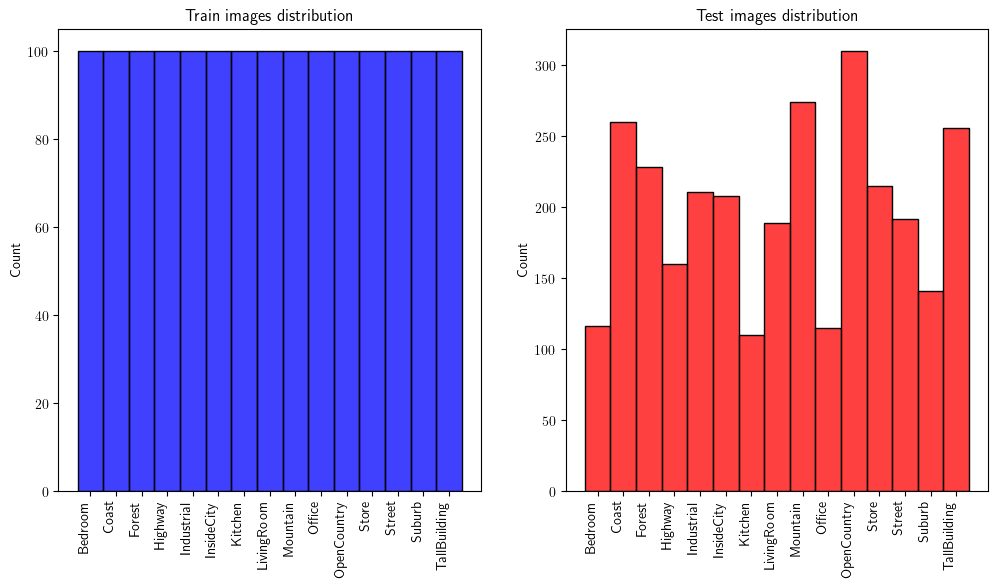

In [4]:
# Classes distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(train_labels, bins=len(classes), ax=ax[0], color="blue", binrange=[0, len(classes)], binwidth=1)
ax[0].set_title("Train images distribution")
ax[0].set_xticks([i + 0.5 for i in range(len(classes))])
ax[0].set_xticklabels(classes, rotation=90, ha='right')

sns.histplot(test_labels, bins=len(classes), ax=ax[1], color="red", binrange=[0, len(classes)], binwidth=1)
ax[1].set_title("Test images distribution")
ax[1].set_xticks([i + 0.5 for i in range(len(classes))])
ax[1].set_xticklabels(classes, rotation=90, ha='right')

plt.show()

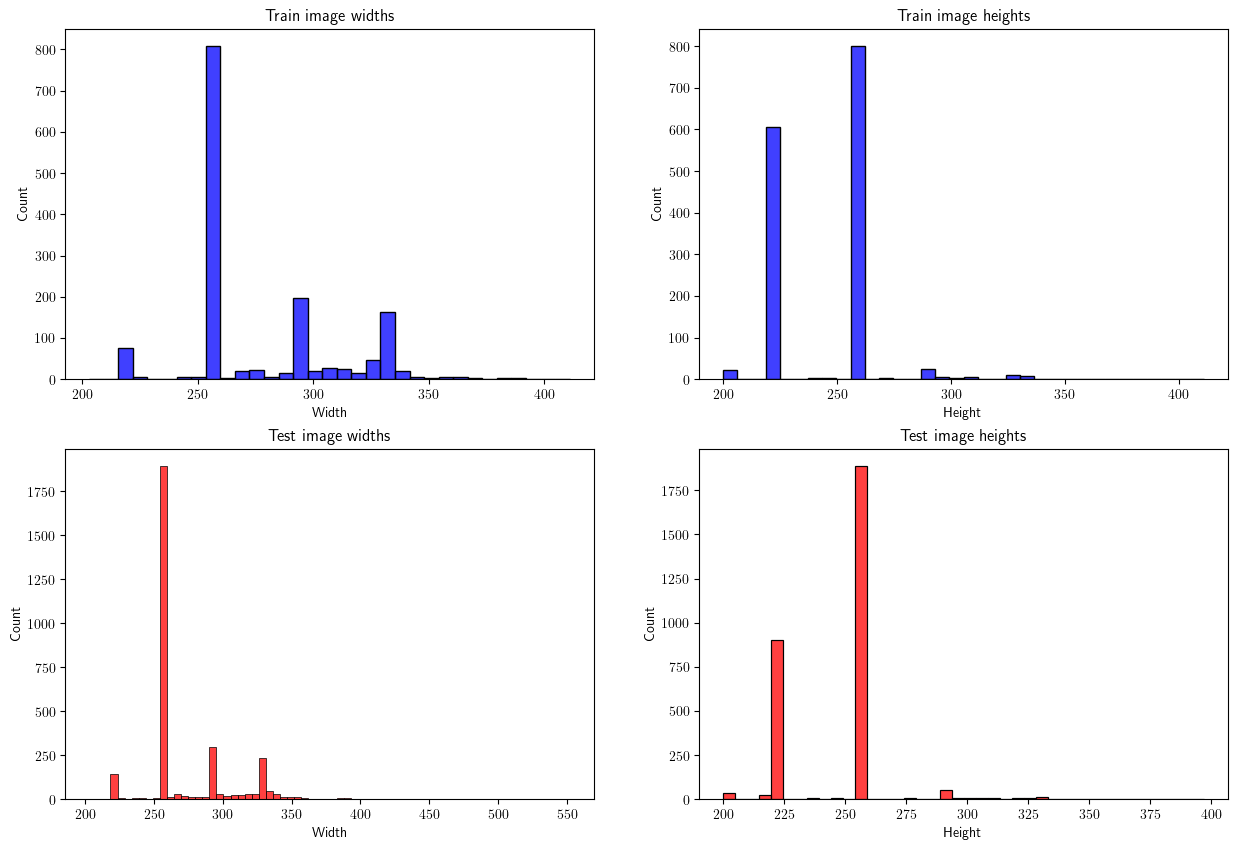

In [5]:
# Sizes of the images

# Measure image sizes
train_widths = [image.shape[1] for image in train_images]
train_heights = [image.shape[0] for image in train_images]
test_widths = [image.shape[1] for image in test_images]
test_heights = [image.shape[0] for image in test_images]

# Plot the image sizes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(train_widths, ax=ax[0, 0], color="blue")
ax[0, 0].set_title("Train image widths")
ax[0, 0].set_xlabel("Width")
ax[0, 0].set_ylabel("Count")

sns.histplot(train_heights, ax=ax[0, 1], color="blue")
ax[0, 1].set_title("Train image heights")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Count")

sns.histplot(test_widths, ax=ax[1, 0], color="red")
ax[1, 0].set_title("Test image widths")
ax[1, 0].set_xlabel("Width")
ax[1, 0].set_ylabel("Count")

sns.histplot(test_heights, ax=ax[1, 1], color="red")
ax[1, 1].set_title("Test image heights")
ax[1, 1].set_xlabel("Height")
ax[1, 1].set_ylabel("Count")

plt.show()

## SIFT Feature Extraction

In [5]:
# Initialize SIFT detector and descriptor
FEATURES = 1000
sift = cv2.SIFT_create(FEATURES)

# Compute the descriptors for the training images
descriptors = []
n_descriptors = []
for image in tqdm.tqdm(train_images, desc="Computing descriptors"):
	_, ds = sift.detectAndCompute(image, None)
	n_descriptors.append(len(ds))
	for d in ds: descriptors.append(d)

descriptors = np.array(descriptors)

print(f"Number of SIFT descriptors: {len(descriptors)}")

Computing descriptors:   0%|          | 0/1500 [00:00<?, ?it/s]

Number of SIFT descriptors: 745692


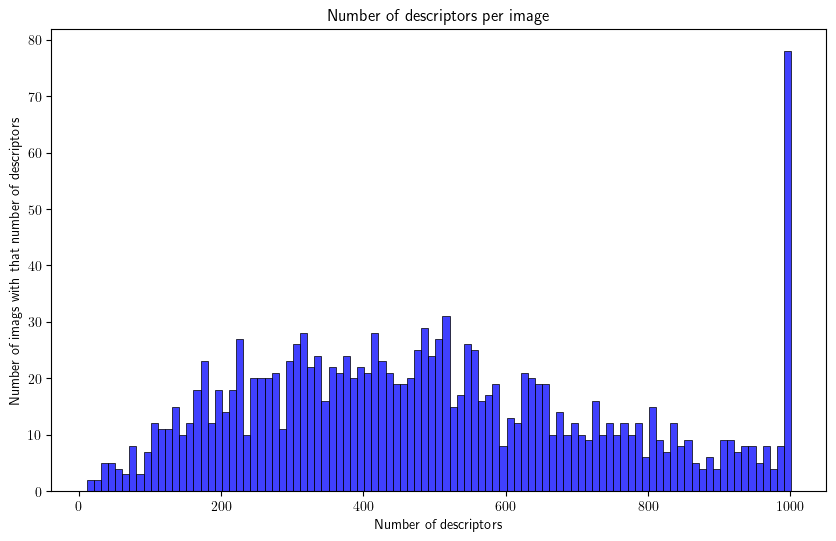

In [7]:
# Histogram of descriptors for each image
plt.figure(figsize=(10, 6))
sns.histplot(n_descriptors, binwidth=10, color="blue")
plt.title("Number of descriptors per image")
plt.xlabel("Number of descriptors")
plt.ylabel("Number of imags with that number of descriptors")
plt.show()

## K-Means Clustering

In [8]:
# Silhouette analysis
# (only for small descriptors numbers due to computational time)
if len(descriptors) > 20000:
	print("Too many descriptors to compute the silhouette analysis")
else:
	# Number of clusters
	k_values = [6, 12, 24, 32, 48, 64, 96]
	silhouette_scores = []

	# Compute the silhouette scores
	for k in tqdm.tqdm(k_values, desc="Computing silhouette scores"):
		kmeans = KMeans(n_clusters=k, random_state=42)
		cluster_labels = kmeans.fit_predict(descriptors)
		silhouette_scores.append(silhouette_score(descriptors, cluster_labels))
	
	# Plot the silhouette scores
	plt.figure(figsize=(10, 6))
	sns.lineplot(x=k_values, y=silhouette_scores, marker="o", color="blue")
	plt.title("Silhouette scores for different number of clusters")
	plt.xlabel("Number of clusters")
	plt.ylabel("Silhouette score")
	plt.show() 
	

Too many descriptors to compute the silhouette analysis


Cluster centers shape: (128, 128)


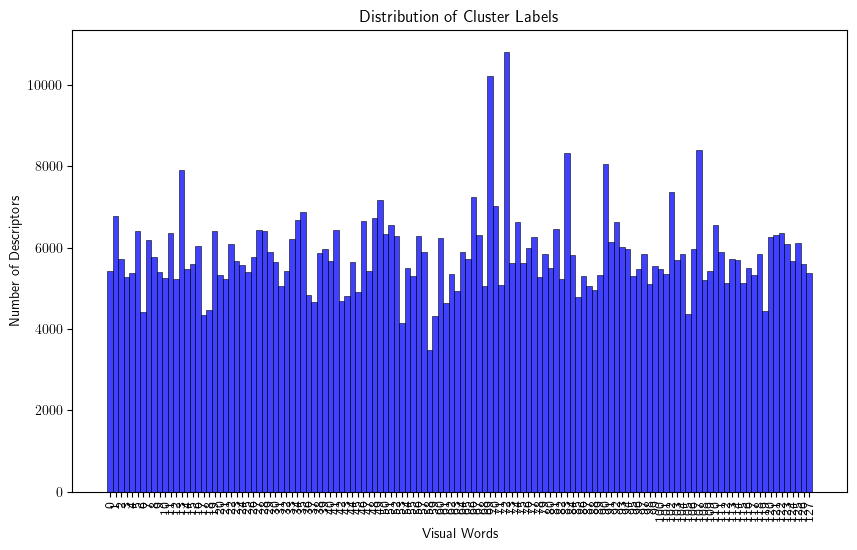

In [6]:
# Number of clusters
k = 128

# Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptors)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print(f"Cluster centers shape: {centroids.shape}")

# Get silhouette score
if len(descriptors) < 20000:
	silhouette_avg = silhouette_score(descriptors, cluster_labels)
	print(f"Silhouette Score: {silhouette_avg}")

# Visual words distribution
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(cluster_labels, bins=k, color="blue", ax=ax, binrange=(0, k), binwidth=1)
ax.set_xticks([i+0.5 for i in range(k)])
ax.set_xticklabels([str(i) for i in range(k)], rotation=90)
ax.set_title('Distribution of Cluster Labels')
ax.set_xlabel('Visual Words')
ax.set_ylabel('Number of Descriptors')

plt.show()


## Normalized Histograms Representation

In [7]:
# Represent images as normalized histograms of k bins, each corresponding to a visual word

# Normalized Histogram Representation function
def normalized_histogram(image, kmeans):
	_, descriptors = sift.detectAndCompute(image, None)
	descriptors = np.array(descriptors)
	histogram = np.zeros(k)
	if descriptors is not None:
		cluster_labels = kmeans.predict(descriptors)
		for label in cluster_labels:
			histogram[label] += 1
	histogram = histogram / len(descriptors)
	return histogram

# Train and test histograms
train_histograms = []
for image in tqdm.tqdm(train_images, desc="Train histograms"):
	histogram = normalized_histogram(image, kmeans)
	train_histograms.append(histogram)
 
train_histograms = np.array(train_histograms) 
print(f"Train histograms shape: {len(train_histograms)}")
 
test_histograms = []
for image in tqdm.tqdm(test_images, desc="Test histograms"):
	histogram = normalized_histogram(image, kmeans)
	test_histograms.append(histogram)
 
test_histograms = np.array(test_histograms)
print(f"Test histograms shape: {len(test_histograms)}")

Train histograms:   0%|          | 0/1500 [00:00<?, ?it/s]

Train histograms shape: 1500


Test histograms:   0%|          | 0/2985 [00:00<?, ?it/s]

Test histograms shape: 2985


Train indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Test indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Computing chi-square distances and intersections:   0%|          | 0/15 [00:00<?, ?it/s]

Plotting histograms: 0it [00:00, ?it/s]

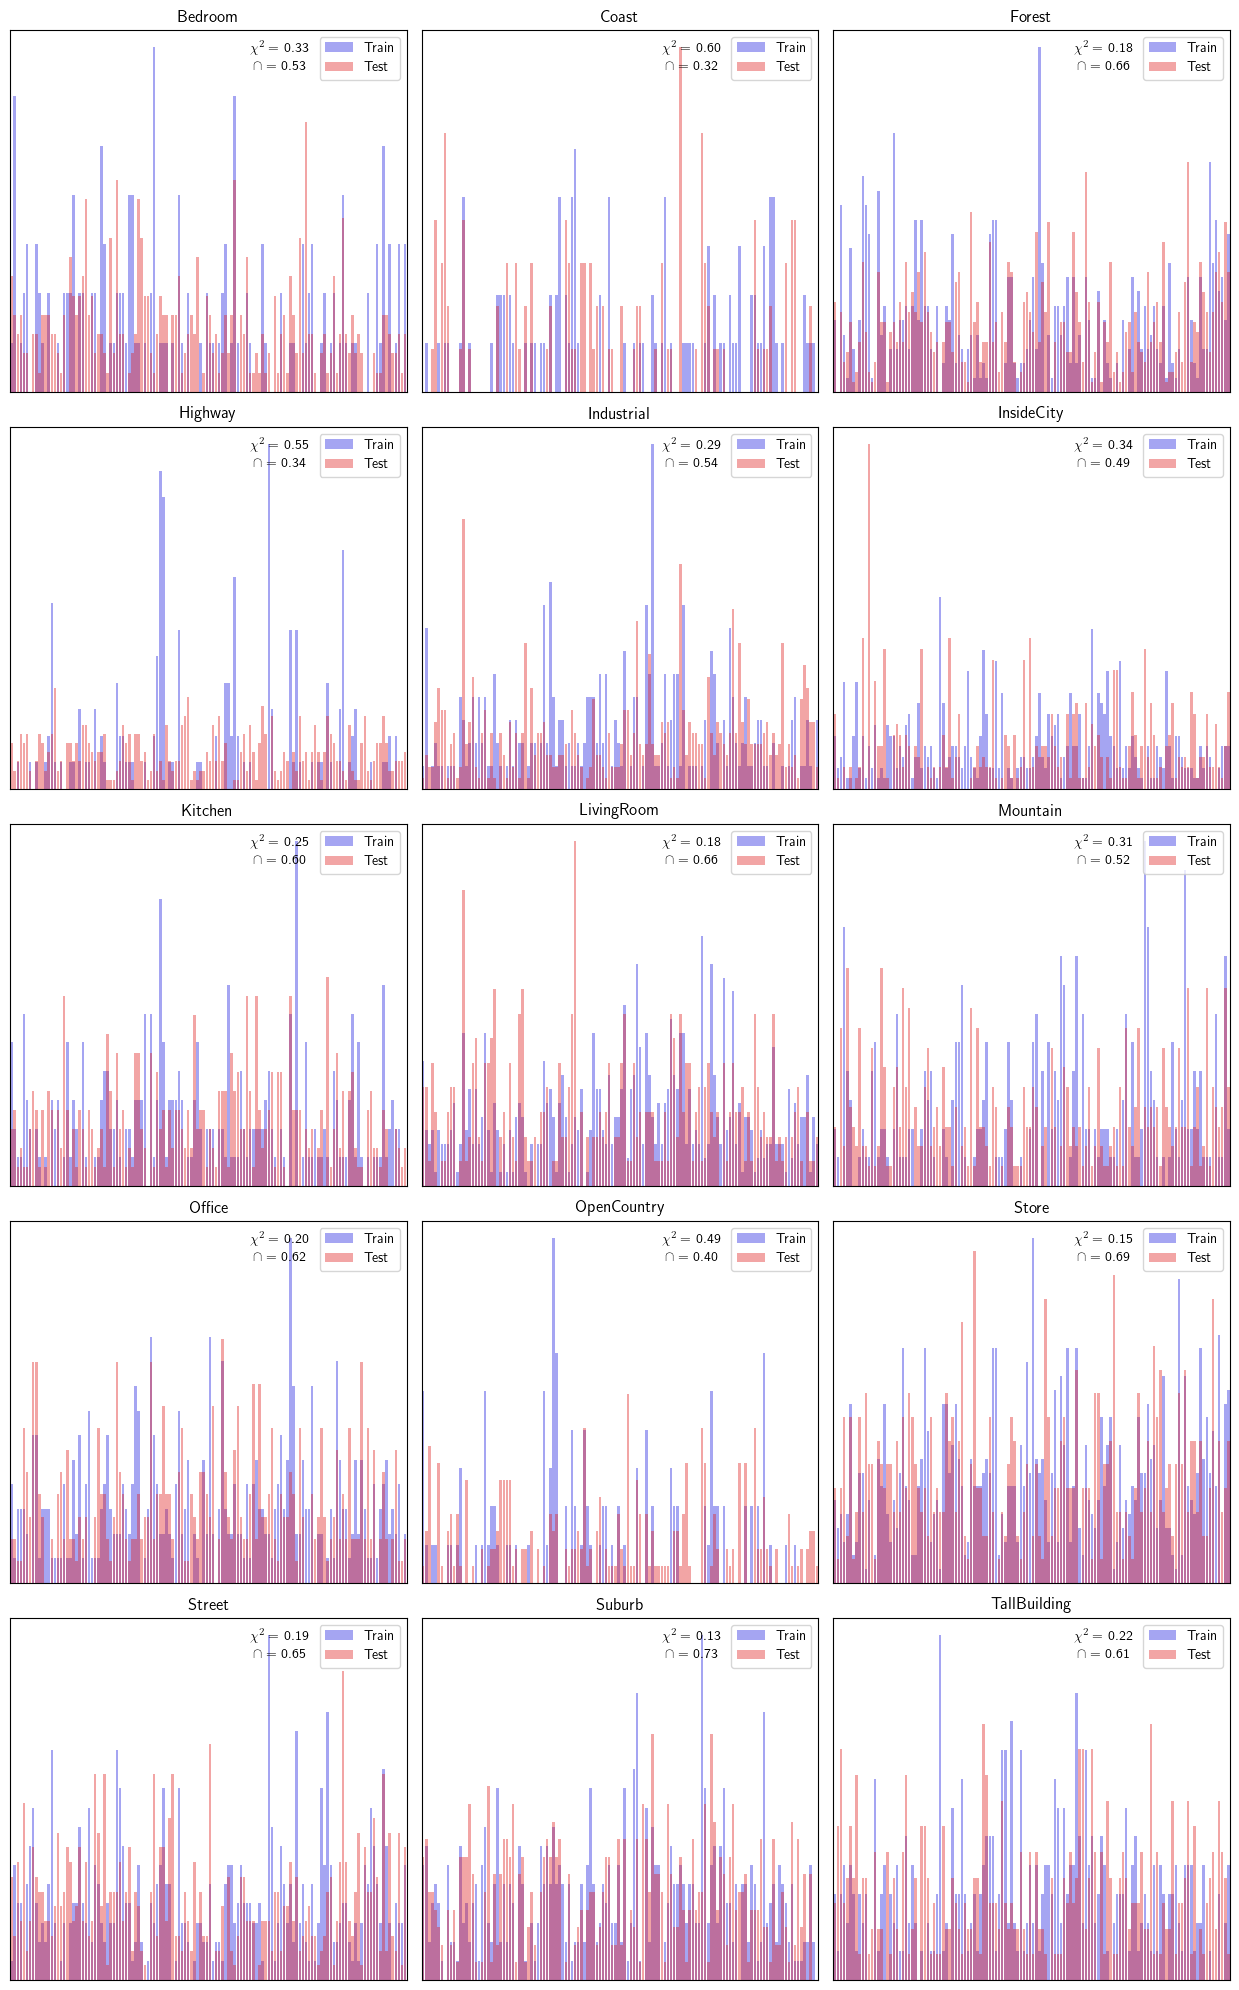

In [11]:
# # Pick random train and test histograms of the same class
# i_train = np.random.randint(len(train_histograms))
# i_test = np.random.randint(len(test_histograms))
# h_train = train_histograms[i_train]
# h_test = test_histograms[i_test]

# # Plot random train / test histograms
# fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# sns.barplot(x=np.arange(k), y=h_train, ax=ax[0], color="blue")
# ax[0].set_title(f"Train histogram of {i_train} image (class {classes[train_labels[i_train]]})")
# ax[0].set_xlabel("Visual words")
# ax[0].set_ylabel("Frequency")
# ax[0].set_ylim(0, 1)

# sns.barplot(x=np.arange(k), y=h_test, ax=ax[1], color="red")
# ax[1].set_title(f"Test histogram of {i_test} image (class {classes[test_labels[i_test]]})")
# ax[1].set_xlabel("Visual words")
# ax[1].set_ylabel("Frequency")
# ax[1].set_ylim(0, 1)

# plt.show()

# Pick a pair of train/test images for each possible class
train_indexes = {class_name: [] for class_name in classes}
test_indexes = {class_name: [] for class_name in classes}

for label in tqdm.tqdm(set(train_labels), desc="Train indexes", leave=False):
	for i, _ in enumerate(train_labels):
		if train_labels[i] == label:
			train_indexes[classes[label]].append(i)
			break

for label in tqdm.tqdm(set(test_labels), desc="Test indexes", leave=False):
	for i, _ in enumerate(test_labels):
		if test_labels[i] == label:
			test_indexes[classes[label]].append(i)
			break

# Collect relative histograms
h_train = []
h_test = []
for class_name in tqdm.tqdm(classes, desc="Collecting histograms", leave=False):
	i_train = train_indexes[class_name][0]
	i_test = test_indexes[class_name][0]
	h_train.append(train_histograms[i_train])
	h_test.append(test_histograms[i_test])

# Compute chi-square distances and intersection for each pair of histograms
def intersection(h1, h2):
	return np.sum(np.minimum(h1, h2))

def chi2_distance(h1, h2):
	return 0.5*np.sum((h1 - h2)**2 / (h1 + h2 + 1e-6))

chi2_distances = np.zeros((len(classes), len(classes)))
intersections = np.zeros((len(classes), len(classes)))
for i in tqdm.tqdm(range(len(classes)), desc="Computing chi-square distances and intersections", leave=False):
	for j in range(len(classes)):
		chi2_distances[i, j] = chi2_distance(h_train[i], h_test[j])
		intersections[i, j] = intersection(h_train[i], h_test[j])

# Plot
fig, ax = plt.subplots(5, 3, figsize=(12.5, 20))
ax = ax.flatten()

# Each subplot is one class (train and test histograms with transparency)
for i, class_name in tqdm.tqdm(enumerate(classes), desc="Plotting histograms", leave=False):
	sns.barplot(x=np.arange(k), y=h_train[i], ax=ax[i], color="blue", alpha=0.4, label="Train")
	sns.barplot(x=np.arange(k), y=h_test[i], ax=ax[i], color="red", alpha=0.4, label="Test")
	ax[i].set_title(f"{class_name}")
	# ax[i].set_xlabel("Visual words")
	# ax[i].set_ylabel("Frequency")
	ax[i].set_xticks([])
	ax[i].set_yticks([])
	ax[i].legend(loc='upper right')
	ax[i].text(0.68, 0.95, r"$\chi^2 =$ " f"{chi2_distances[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
	ax[i].text(0.68, 0.90, r"$\cap =$ " f"{intersections[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
				 
plt.tight_layout()
plt.show()  

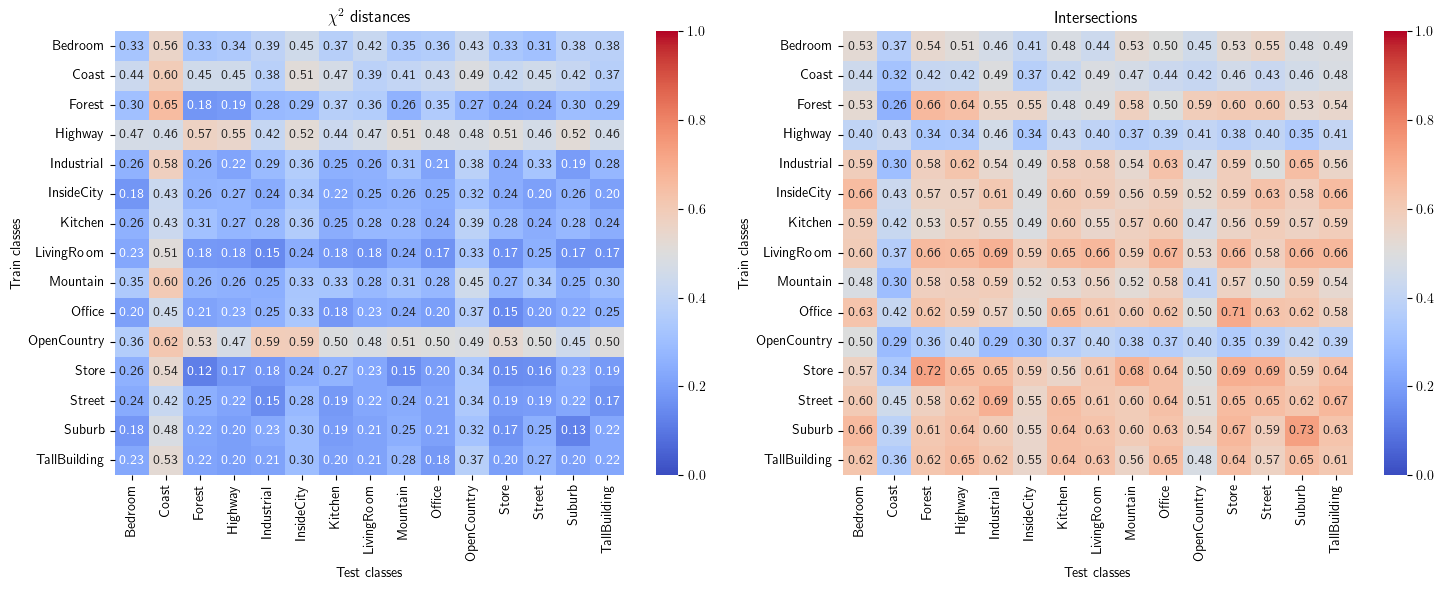

In [12]:
# Heatmaps of chi-square distances and intersections
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(
	chi2_distances, 
	annot=True, 
	fmt=".2f", 
	vmin=0,
	vmax = 1,
	cmap="coolwarm", 
	ax=ax[0], 
	xticklabels=classes, 
	yticklabels=classes
)
ax[0].set_title(r"$\chi^2$ distances")
ax[0].set_xlabel("Test classes")
ax[0].set_ylabel("Train classes")

sns.heatmap(
	intersections,
	annot=True,
	fmt=".2f",
	vmin=0,
	vmax=1,
	cmap="coolwarm",
	ax=ax[1],
	xticklabels=classes,
	yticklabels=classes
)
ax[1].set_title("Intersections")
ax[1].set_xlabel("Test classes")
ax[1].set_ylabel("Train classes")

plt.tight_layout()
plt.show()

## Term Frequency-Inverse Document Frequency (TF-IDF) Transformation

In [12]:
# Term Frequency - Inverse Document Frequency (TF-IDF) function
def tfidf(images, kmeans):
	
	# Initialize variables
	# - n_id = occurences of word i in document d
	# - n_d = total number of words in document d
	# - N_i = number of documents containing word i
	# - N = total number of documents
	N = len(images)
	N_i = np.zeros(k)
	n_id = []
	n_d = []
 
	# Fill the variables
	for image in tqdm.tqdm(images, desc="Computing TF-IDF"):
     
		_, descriptors = sift.detectAndCompute(image, None)
		descriptors = np.array(descriptors)
		histogram = np.zeros(k)
  
		if descriptors is not None:
			words_descriptors = set()
			cluster_labels = kmeans.predict(descriptors)
   
			for label in cluster_labels:
				histogram[label] += 1
				words_descriptors.add(label)
    
			for word in words_descriptors:
				N_i[word] += 1

		n_id.append(histogram)
		n_d.append(len(descriptors))
	
	n_id = np.array(n_id)
	n_d = np.array(n_d)
 
	# Compute the TF-IDF for each image and word in that image
	tfidf_images = []
	for i in range(N):
		tfidf_image = np.zeros(k)
		for j in range(k):
			tfidf_image[j] = (n_id[i, j] / n_d[i]) * np.log(N / N_i[j])
		tfidf_images.append(tfidf_image)
  
	return np.array(tfidf_images)
	
# Train and test TF-IDF
train_tfidf = tfidf(train_images, kmeans)
test_tfidf = tfidf(test_images, kmeans)

Computing TF-IDF:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing TF-IDF:   0%|          | 0/2985 [00:00<?, ?it/s]

Train indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Test indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Plotting tf-idf: 0it [00:00, ?it/s]

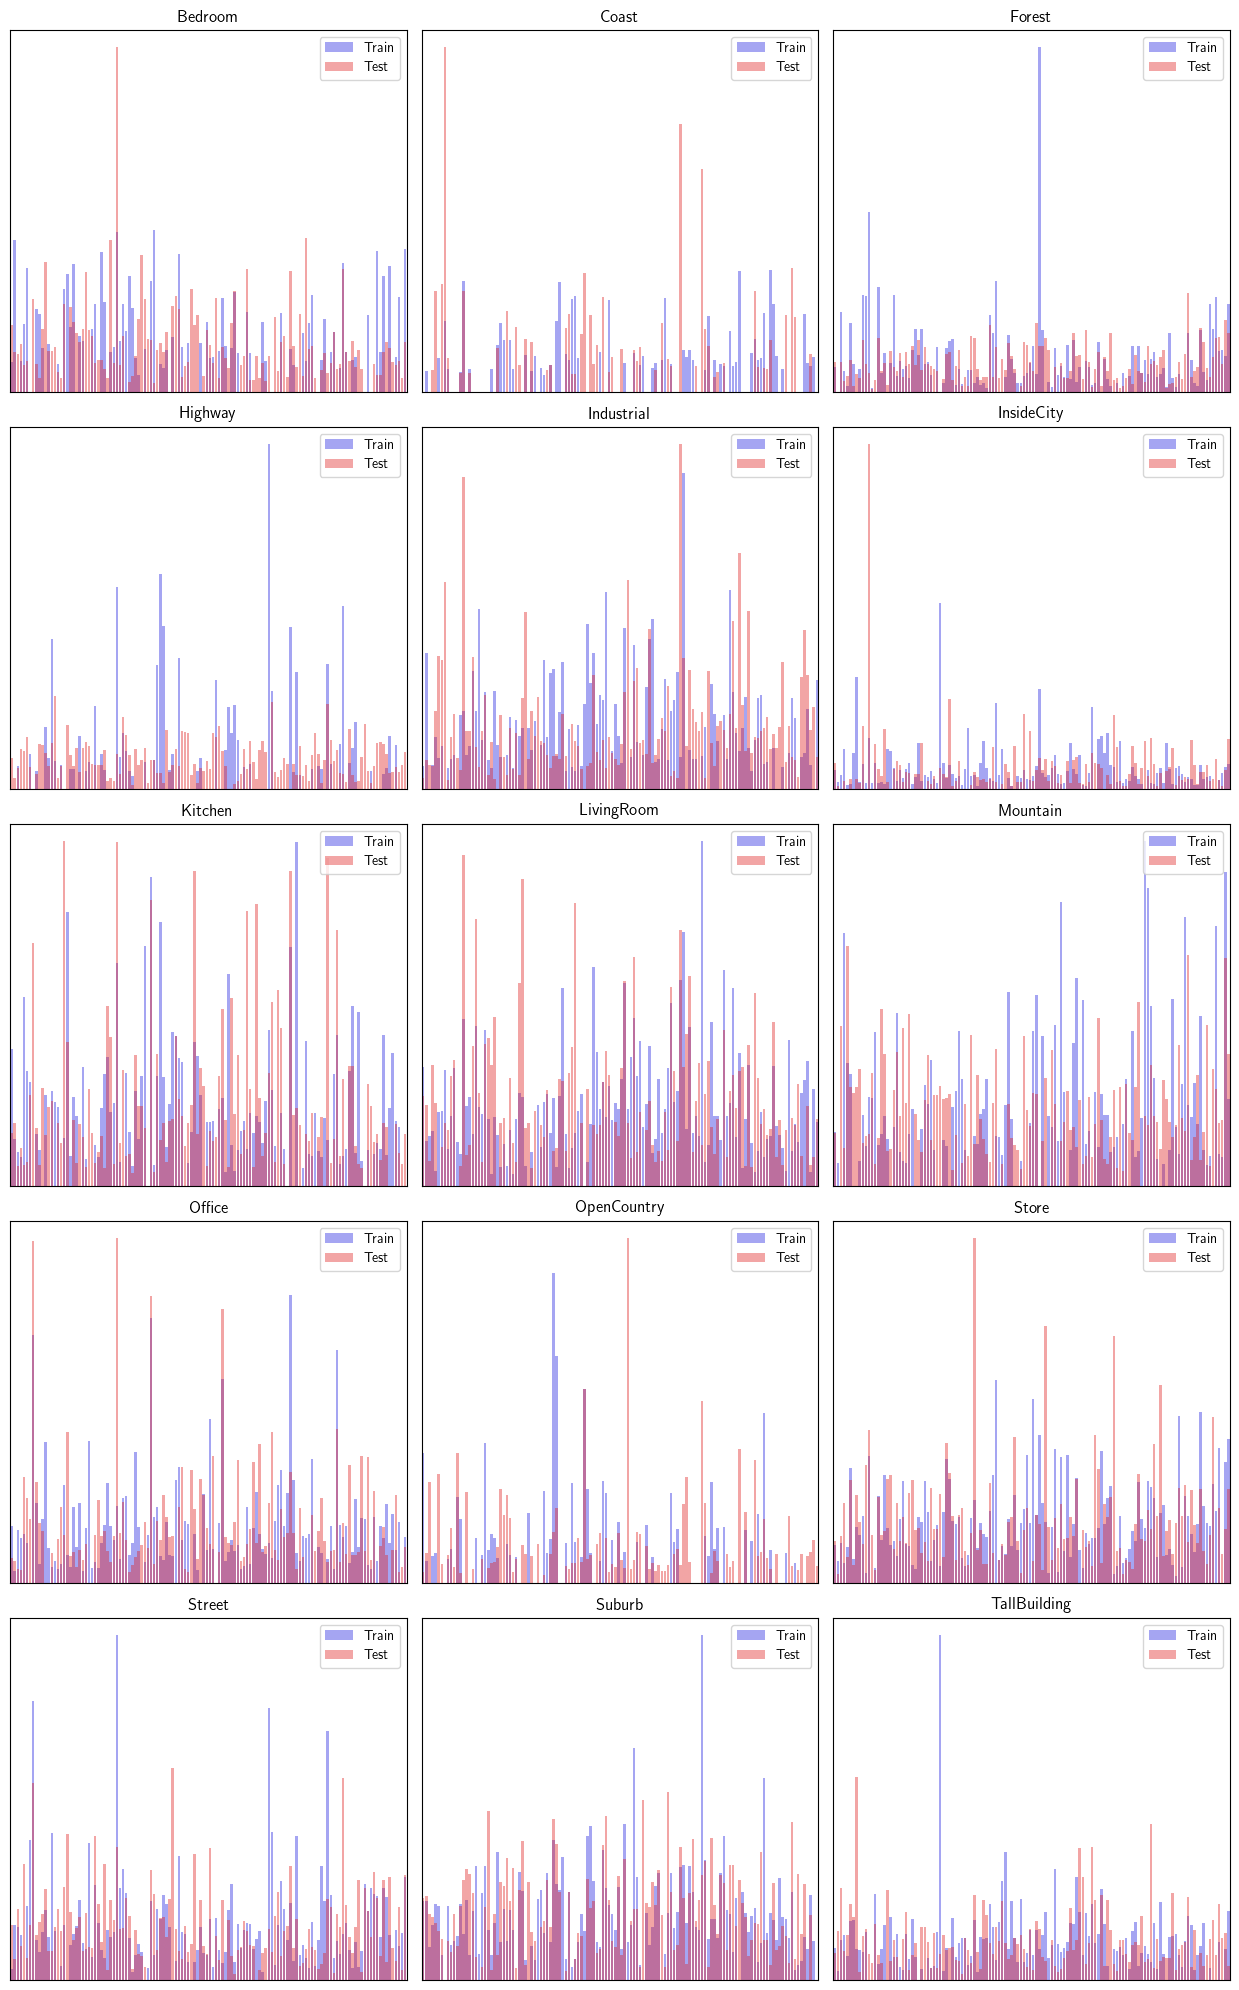

In [16]:
# Pick a pair of train/test images for each possible class
train_indexes = {class_name: [] for class_name in classes}
test_indexes = {class_name: [] for class_name in classes}

for label in tqdm.tqdm(set(train_labels), desc="Train indexes", leave=False):
	for i, _ in enumerate(train_labels):
		if train_labels[i] == label:
			train_indexes[classes[label]].append(i)
			break

for label in tqdm.tqdm(set(test_labels), desc="Test indexes", leave=False):
	for i, _ in enumerate(test_labels):
		if test_labels[i] == label:
			test_indexes[classes[label]].append(i)
			break

# Collect relative tf-idf
t_train = []
t_test = []
for class_name in tqdm.tqdm(classes, desc="Collecting histograms", leave=False):
	i_train = train_indexes[class_name][0]
	i_test = test_indexes[class_name][0]
	t_train.append(train_tfidf[i_train])
	t_test.append(test_tfidf[i_test])

# Plot
fig, ax = plt.subplots(5, 3, figsize=(12.5, 20))
ax = ax.flatten()

# Each subplot is one class (train and test histograms with transparency)
for i, class_name in tqdm.tqdm(enumerate(classes), desc="Plotting tf-idf", leave=False):
	sns.barplot(x=np.arange(k), y=t_train[i], ax=ax[i], color="blue", alpha=0.4, label="Train")
	sns.barplot(x=np.arange(k), y=t_test[i], ax=ax[i], color="red", alpha=0.4, label="Test")
	ax[i].set_title(f"{class_name}")
	ax[i].set_xticks([])
	ax[i].set_yticks([])
	ax[i].legend(loc='upper right')
				 
plt.tight_layout()
plt.show()  


## K-Nearest Neighbors Classifier

Testing k-NN values:   0%|          | 0/50 [00:00<?, ?it/s]

Best k: 15
Accuracy: 0.39095477386934674


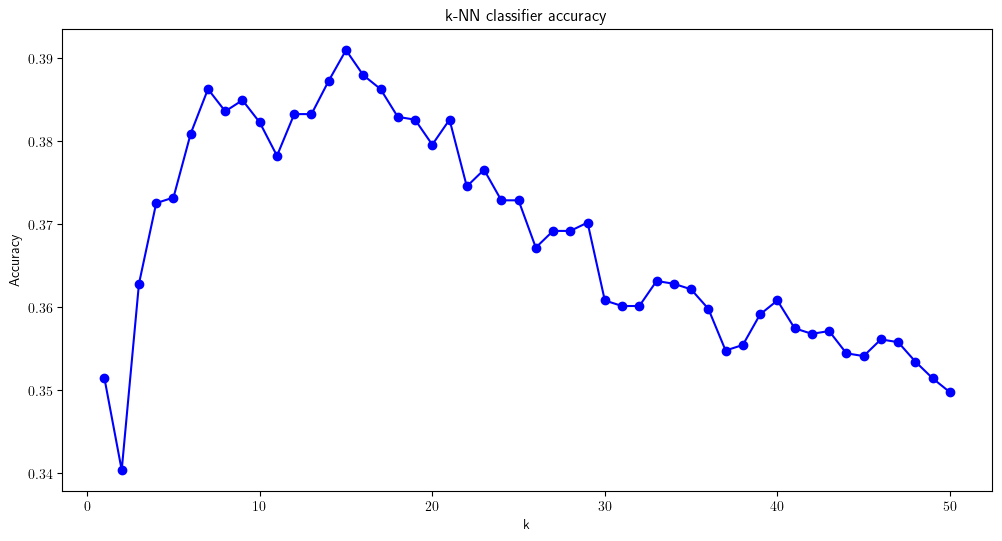

In [321]:
# Employ and asses a nearest neighbor classifier

# Test different values of k neighbors
k_values = range(1, 51)
accuracies = []

for k_ in tqdm.tqdm(k_values, desc="Testing k-NN values"):
	# Train k-NN classifier
	knn = KNeighborsClassifier(n_neighbors=k_)
	knn.fit(train_histograms, train_labels)

	# Predict labels for test set
	test_predictions = knn.predict(test_histograms)

	# Calculate accuracy
	accuracy = accuracy_score(test_labels, test_predictions)
	accuracies.append(accuracy)

# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")

# Initialize k-NN classifier with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train_histograms, train_labels)
test_predictions = knn.predict(test_histograms)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy}")

# Plot the accuracy for different values of k
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', color='blue')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN classifier accuracy')
plt.show()


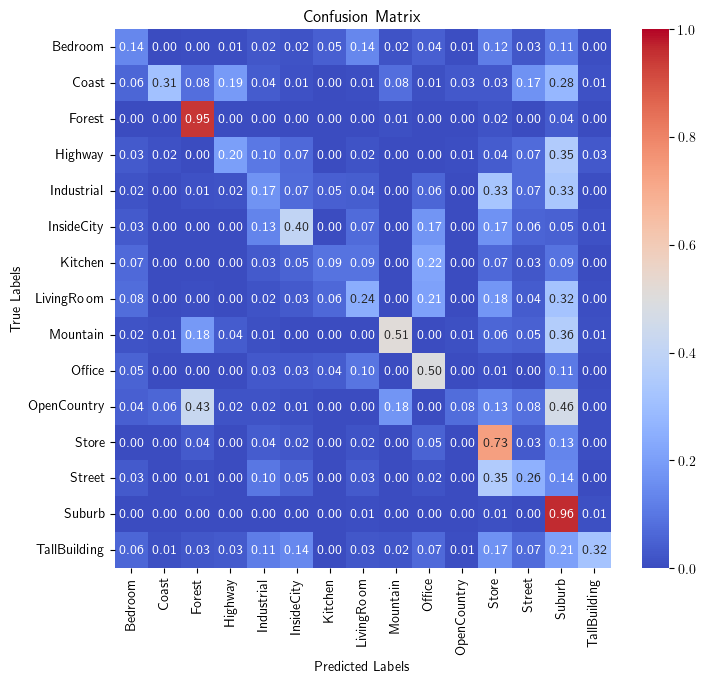

In [322]:
# k-NN classifier confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
plt.figure(figsize=(8, 7))
sns.heatmap(
	conf_matrix, 
	annot=True, 
	fmt='.2f', 
	vmin = 0,
	vmax = 1,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Support Vector Machine (SVM) Classifier

In [323]:
# One-vs-all SVM classifiers
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs"):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='rbf')
	svm.fit(train_histograms, one_vs_all_labels)
	SVMs.append(svm)

print(f"Trained {len(SVMs)} SVMs")

# Multi-class prediction function
def multi_svm_predict(SVMs, x):
	predictions = []
	for svm in SVMs:
		y_hat = svm.decision_function([x])[0]
		predictions.append(y_hat)

	return np.argmax(predictions) 

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Trained 15 SVMs


Predicting test set with SVMs:   0%|          | 0/2985 [00:00<?, ?it/s]

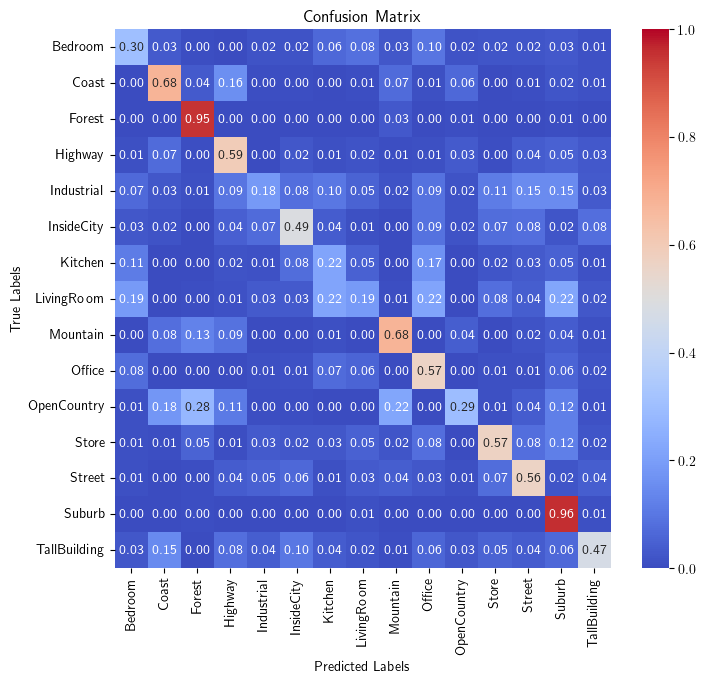

In [324]:
# Predict for all test cases and build confusion matrix
svm_test_predictions = []
for x in tqdm.tqdm(test_histograms, desc="Predicting test set with SVMs"):
	svm_test_predictions.append(multi_svm_predict(SVMs, x))
 
# Compute confusion matrix
svm_conf_matrix = confusion_matrix(test_labels, svm_test_predictions)
svm_conf_matrix = svm_conf_matrix / np.sum(svm_conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	svm_conf_matrix, 
	annot=True, 
	fmt='.2f', 
	vmin = 0,
	vmax = 1,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## SVM with specialized kernels

In [10]:
# One-vs-all SVM classifiers with chi-square kernel
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs"):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Compute chi-square kernel matrix
	train_chi2_kernel = chi2_kernel(train_histograms, train_histograms, gamma=0.5)
 
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='precomputed')
	svm.fit(train_chi2_kernel, one_vs_all_labels)
	SVMs.append(svm)

print(f"Trained {len(SVMs)} SVMs")

# Multi-class prediction function
def multi_svm_predict(SVMs, x):
	predictions = []
	for svm in SVMs:
		# Compute chi-square kernel
		x_train = np.array([x])
		chi2_kernel_matrix = chi2_kernel(x_train, train_histograms, gamma=0.5)
		y_hat = svm.decision_function(chi2_kernel_matrix)[0]
		predictions.append(y_hat)

	return np.argmax(predictions) 

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Trained 15 SVMs


Predicting test set with SVMs:   0%|          | 0/2985 [00:00<?, ?it/s]

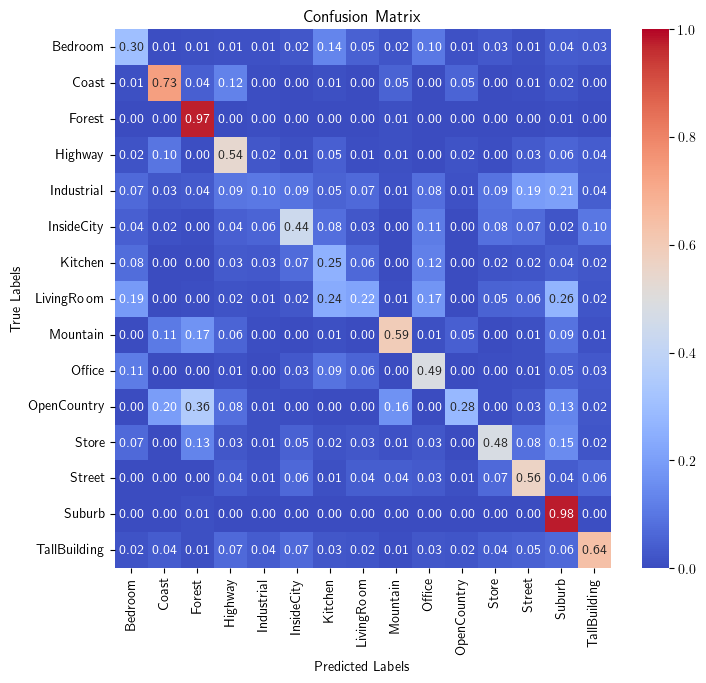

In [11]:
# Predict for all test cases and build confusion matrix
svm_test_predictions = []
for x in tqdm.tqdm(test_histograms, desc="Predicting test set with SVMs"):
	svm_test_predictions.append(multi_svm_predict(SVMs, x))
 
# Compute confusion matrix
svm_conf_matrix = confusion_matrix(test_labels, svm_test_predictions)
svm_conf_matrix = svm_conf_matrix / np.sum(svm_conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	svm_conf_matrix, 
	annot=True, 
	fmt='.2f', 
	vmin = 0,
	vmax = 1,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



## SVM with tf-idf

In [17]:
# One-vs-all SVM classifiers
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs"):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='rbf')
	svm.fit(train_tfidf, one_vs_all_labels)
	SVMs.append(svm)

print(f"Trained {len(SVMs)} SVMs")

# Multi-class prediction function
def multi_svm_predict(SVMs, x):
	predictions = []
	for svm in SVMs:
		y_hat = svm.decision_function([x])[0]
		predictions.append(y_hat)

	return np.argmax(predictions)

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Trained 15 SVMs


Predicting test set with SVMs:   0%|          | 0/2985 [00:00<?, ?it/s]

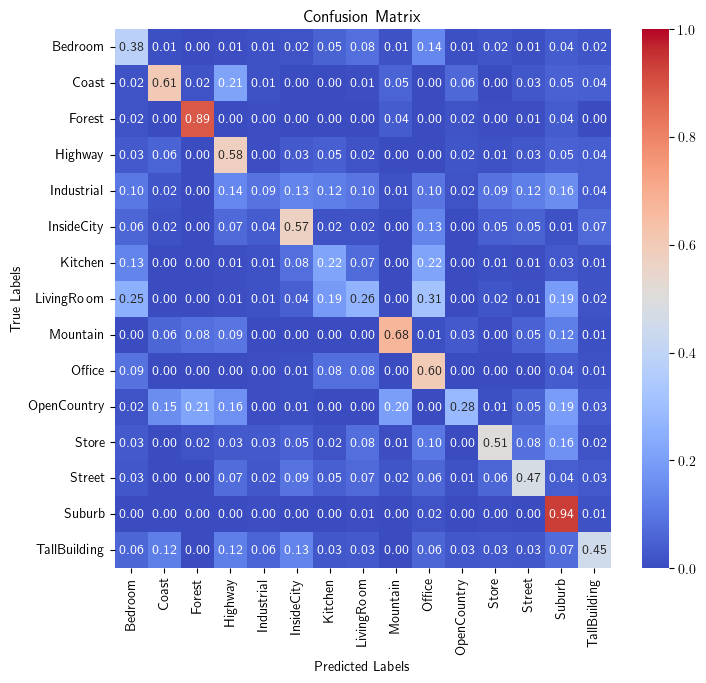

In [18]:
# Predict for all test cases and build confusion matrix
svm_test_predictions = []
for x in tqdm.tqdm(test_tfidf, desc="Predicting test set with SVMs"):
	svm_test_predictions.append(multi_svm_predict(SVMs, x))
 
# Compute confusion matrix
svm_conf_matrix = confusion_matrix(test_labels, svm_test_predictions)
svm_conf_matrix = svm_conf_matrix / np.sum(svm_conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	svm_conf_matrix, 
	annot=True, 
	fmt='.2f', 
	vmin = 0,
	vmax = 1,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## SVM with tf-idf and specialized kernels

In [13]:

# One-vs-all SVM classifiers with chi-square kernel
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs"):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Compute chi-square kernel matrix
	train_chi2_kernel = chi2_kernel(train_tfidf, train_tfidf)
 
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='precomputed')
	svm.fit(train_chi2_kernel, one_vs_all_labels)
	SVMs.append(svm)

print(f"Trained {len(SVMs)} SVMs")

# Multi-class prediction function
def multi_svm_predict(SVMs, x):
	predictions = []
	for svm in SVMs:
		# Compute chi-square kernel
		x_train = np.array([x])
		chi2_kernel_matrix = chi2_kernel(x_train, train_tfidf)
		y_hat = svm.decision_function(chi2_kernel_matrix)[0]
		predictions.append(y_hat)

	return np.argmax(predictions) 

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Trained 15 SVMs


Predicting test set with SVMs:   0%|          | 0/2985 [00:00<?, ?it/s]

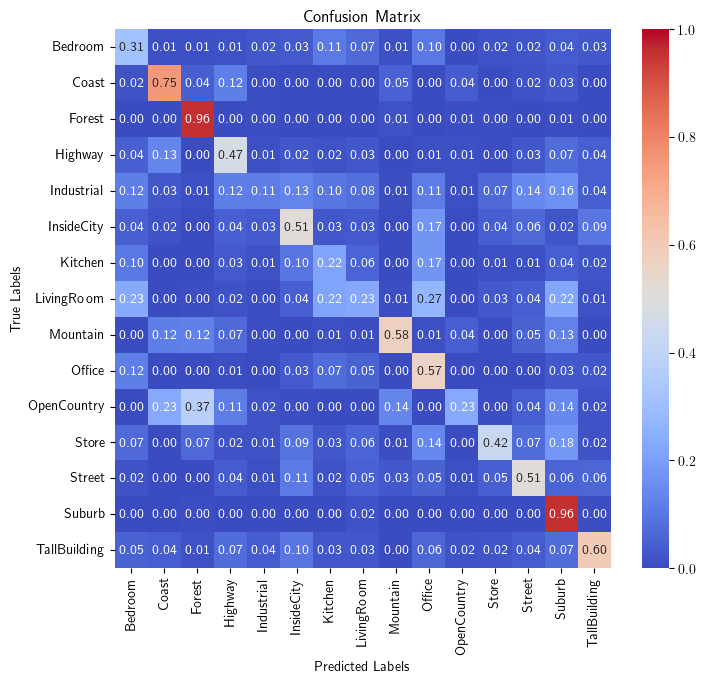

In [14]:
# Predict for all test cases and build confusion matrix
svm_test_predictions = []
for x in tqdm.tqdm(test_tfidf, desc="Predicting test set with SVMs"):
	svm_test_predictions.append(multi_svm_predict(SVMs, x))
 
# Compute confusion matrix
svm_conf_matrix = confusion_matrix(test_labels, svm_test_predictions)
svm_conf_matrix = svm_conf_matrix / np.sum(svm_conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	svm_conf_matrix, 
	annot=True, 
	fmt='.2f', 
	vmin = 0,
	vmax = 1,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()